“KD静态文本特征分析实验1”，主要是分析Kevin Killourhy提供的数据（.tie5Roanl），看其是否能作为用户的“typing DNA”?这里将尽量复现Kevin的工作（根据他提供的R代码），在此基础上，增加近期的一些方法，看能否在静态文本中找到“typing DNA”的证据。
问题：
1.数据是否能区分用户sujbect?
  针对这个问题，我们需要对数据进行预处理，去离群点，选择合适的分离器，训练分离器，调参，评价分类器。
2.如何解释结果？
  在做上述工作时，需要考虑模型的可解释性。如果得到一个较好结果，但无法解释，那会十分遗憾。

导入基本包，加载数据

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#不显示warning，为了好看用。需要显示warning时，注释下面两行
import warnings
warnings.filterwarnings('ignore')

加载数据

In [2]:
df = pd.read_csv('DSL-StrongPasswordData.csv')
df.shape

(20400, 34)

In [3]:
#对用户进行label编码，即从0编到50.
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['target'] = le.fit_transform(df['subject'])
df.drop(['subject'], axis=1, inplace=True)
df.head()

sessionIndex  rep  H.period  DD.period.t  UD.period.t     H.t  DD.t.i  \
0             1    1    0.1491       0.3979       0.2488  0.1069  0.1674   
1             1    2    0.1111       0.3451       0.2340  0.0694  0.1283   
2             1    3    0.1328       0.2072       0.0744  0.0731  0.1291   
3             1    4    0.1291       0.2515       0.1224  0.1059  0.2495   
4             1    5    0.1249       0.2317       0.1068  0.0895  0.1676   

   UD.t.i     H.i  DD.i.e   ...    DD.a.n  UD.a.n     H.n  DD.n.l  UD.n.l  \
0  0.0605  0.1169  0.2212   ...    0.1484  0.0135  0.0932  0.3515  0.2583   
1  0.0589  0.0908  0.1357   ...    0.2558  0.1146  0.1146  0.2642  0.1496   
2  0.0560  0.0821  0.1542   ...    0.2332  0.0711  0.1172  0.2705  0.1533   
3  0.1436  0.1040  0.2038   ...    0.1629  0.0172  0.0866  0.2341  0.1475   
4  0.0781  0.0903  0.1589   ...    0.1582  0.0270  0.0884  0.2517  0.1633   

      H.l  DD.l.Return  UD.l.Return  H.Return  target  
0  0.1338       0.3509       0.2171    0.0742       0  
1  0.0839       0.2756       0.1917    0.0747       0  
2  0.1085       0.2847       0.1762    0.0945       0  
3  0.0845       0.3232       0.2387    0.0813       0  
4  0.0903       0.2517       0.1614    0.0818       0  

[5 rows x 34 columns]

In [4]:
#检查数据中是否有空值
df.isnull().any().any() 

False

In [5]:
#拆分数据
ud_features = [column for column in df.columns if 'UD' in column]
dd_features = [column for column in df.columns if 'DD' in column]
hold_features = [column for column in df.columns if 'H' in column]

查看数据基本情况

In [6]:
df[ud_features].describe()

UD.period.t        UD.t.i        UD.i.e     UD.e.five  \
count  20400.000000  20400.000000  20400.000000  20400.000000   
mean       0.170769      0.083358      0.077806      0.288295   
std        0.226836      0.125755      0.228512      0.266695   
min       -0.235800     -0.162100     -0.160000     -0.150500   
25%        0.049800      0.027200      0.007400      0.133200   
50%        0.108700      0.057800      0.041200      0.200400   
75%        0.212400      0.096400      0.093400      0.369400   
max       12.451700      4.799900     25.915800      4.882700   

       UD.five.Shift.r  UD.Shift.r.o        UD.o.a        UD.a.n  \
count     20400.000000  20400.000000  20400.000000  20400.000000   
mean          0.361983      0.154984      0.068577      0.044411   
std           0.260886      0.181619      0.108509      0.105197   
min           0.085600     -0.086500     -0.228700     -0.235500   
25%           0.229675      0.054700      0.017000     -0.009000   
50%           0.302000      0.102200      0.044400      0.022700   
75%           0.408900      0.191000      0.080300      0.068900   
max           8.290800      4.012000      2.815200      2.524200   

             UD.n.l   UD.l.Return  
count  20400.000000  20400.000000  
mean       0.112731      0.226259  
std        0.159571      0.230759  
min       -0.175800     -0.124500  
25%        0.023500      0.114100  
50%        0.095500      0.160300  
75%        0.145700      0.255100  
max        3.978200      5.836400

In [7]:
df[dd_features].describe()

DD.period.t        DD.t.i        DD.i.e     DD.e.five  \
count  20400.000000  20400.000000  20400.000000  20400.000000   
mean       0.264148      0.169085      0.159372      0.377434   
std        0.220534      0.123546      0.226928      0.265342   
min        0.018700      0.001100      0.001400      0.001300   
25%        0.146900      0.113600      0.089300      0.216600   
50%        0.205950      0.140400      0.120900      0.289000   
75%        0.306450      0.183900      0.173100      0.456850   
max       12.506100      4.919700     25.987300      4.961800   

       DD.five.Shift.r  DD.Shift.r.o        DD.o.a        DD.a.n  \
count     20400.000000  20400.000000  20400.000000  20400.000000   
mean          0.438887      0.250921      0.156931      0.150670   
std           0.260343      0.174533      0.106557      0.107422   
min           0.169400      0.049400      0.001200      0.001100   
25%           0.307900      0.156500      0.106400      0.096100   
50%           0.377500      0.201350      0.131600      0.125000   
75%           0.486025      0.283425      0.167600      0.174600   
max           8.370200      4.152300      2.856700      3.327800   

             DD.n.l   DD.l.Return  
count  20400.000000  20400.000000  
mean       0.202630      0.321847  
std        0.150191      0.225389  
min        0.001300      0.008300  
25%        0.127600      0.210000  
50%        0.172500      0.263000  
75%        0.228800      0.350200  
max        4.025200      5.883600

In [8]:
df[hold_features].describe()

H.period           H.t           H.i           H.e        H.five  \
count  20400.000000  20400.000000  20400.000000  20400.000000  20400.000000   
mean       0.093379      0.085727      0.081565      0.089138      0.076904   
std        0.029626      0.027424      0.026887      0.030635      0.021746   
min        0.001400      0.009300      0.003200      0.002100      0.001400   
25%        0.074400      0.066000      0.062000      0.068600      0.061000   
50%        0.089500      0.081000      0.077100      0.083400      0.074200   
75%        0.107900      0.099800      0.096900      0.102700      0.090600   
max        0.376100      0.241100      0.331200      0.325400      0.198900   

          H.Shift.r           H.o           H.a           H.n           H.l  \
count  20400.000000  20400.000000  20400.000000  20400.000000  20400.000000   
mean       0.095937      0.088354      0.106259      0.089899      0.095589   
std        0.033900      0.026427      0.038828      0.030738      0.028348   
min        0.001400      0.006900      0.004000      0.003700      0.003700   
25%        0.070200      0.071500      0.082100      0.067300      0.077400   
50%        0.093500      0.086300      0.101900      0.085300      0.093700   
75%        0.116700      0.101900      0.122300      0.107900      0.111100   
max        0.281700      0.687200      2.035300      0.357700      0.340700   

           H.Return  
count  20400.000000  
mean       0.088306  
std        0.027452  
min        0.002900  
25%        0.069900  
50%        0.085500  
75%        0.103700  
max        0.265100

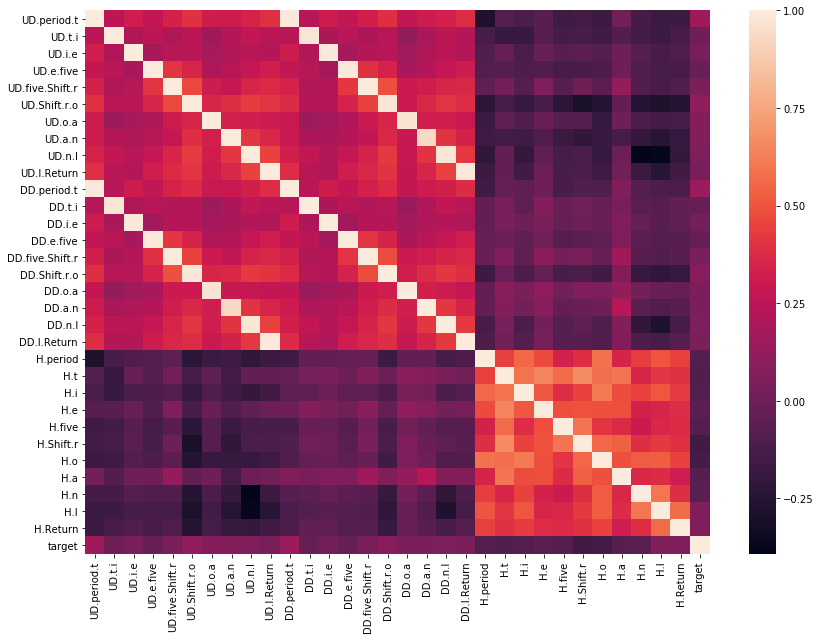

In [10]:
#画热力图，看各属性间是否存在相关性
plt.figure(figsize=(14, 10))
sns.heatmap(df[ud_features + dd_features + hold_features + ['target']].corr())

从热力图上可以初步判断：
1.H特征之间有强烈的相关性，可以推测出，每个人在不同的字符上有自己的“延迟”。
2.DD和UD特征也强烈相关。因为它们之前的联系为：DD = UD + Hold，所以可以在DD和UD特征之前选一个保留。

下面分别查看H和UD的pairplot,可以看到一些outlier。

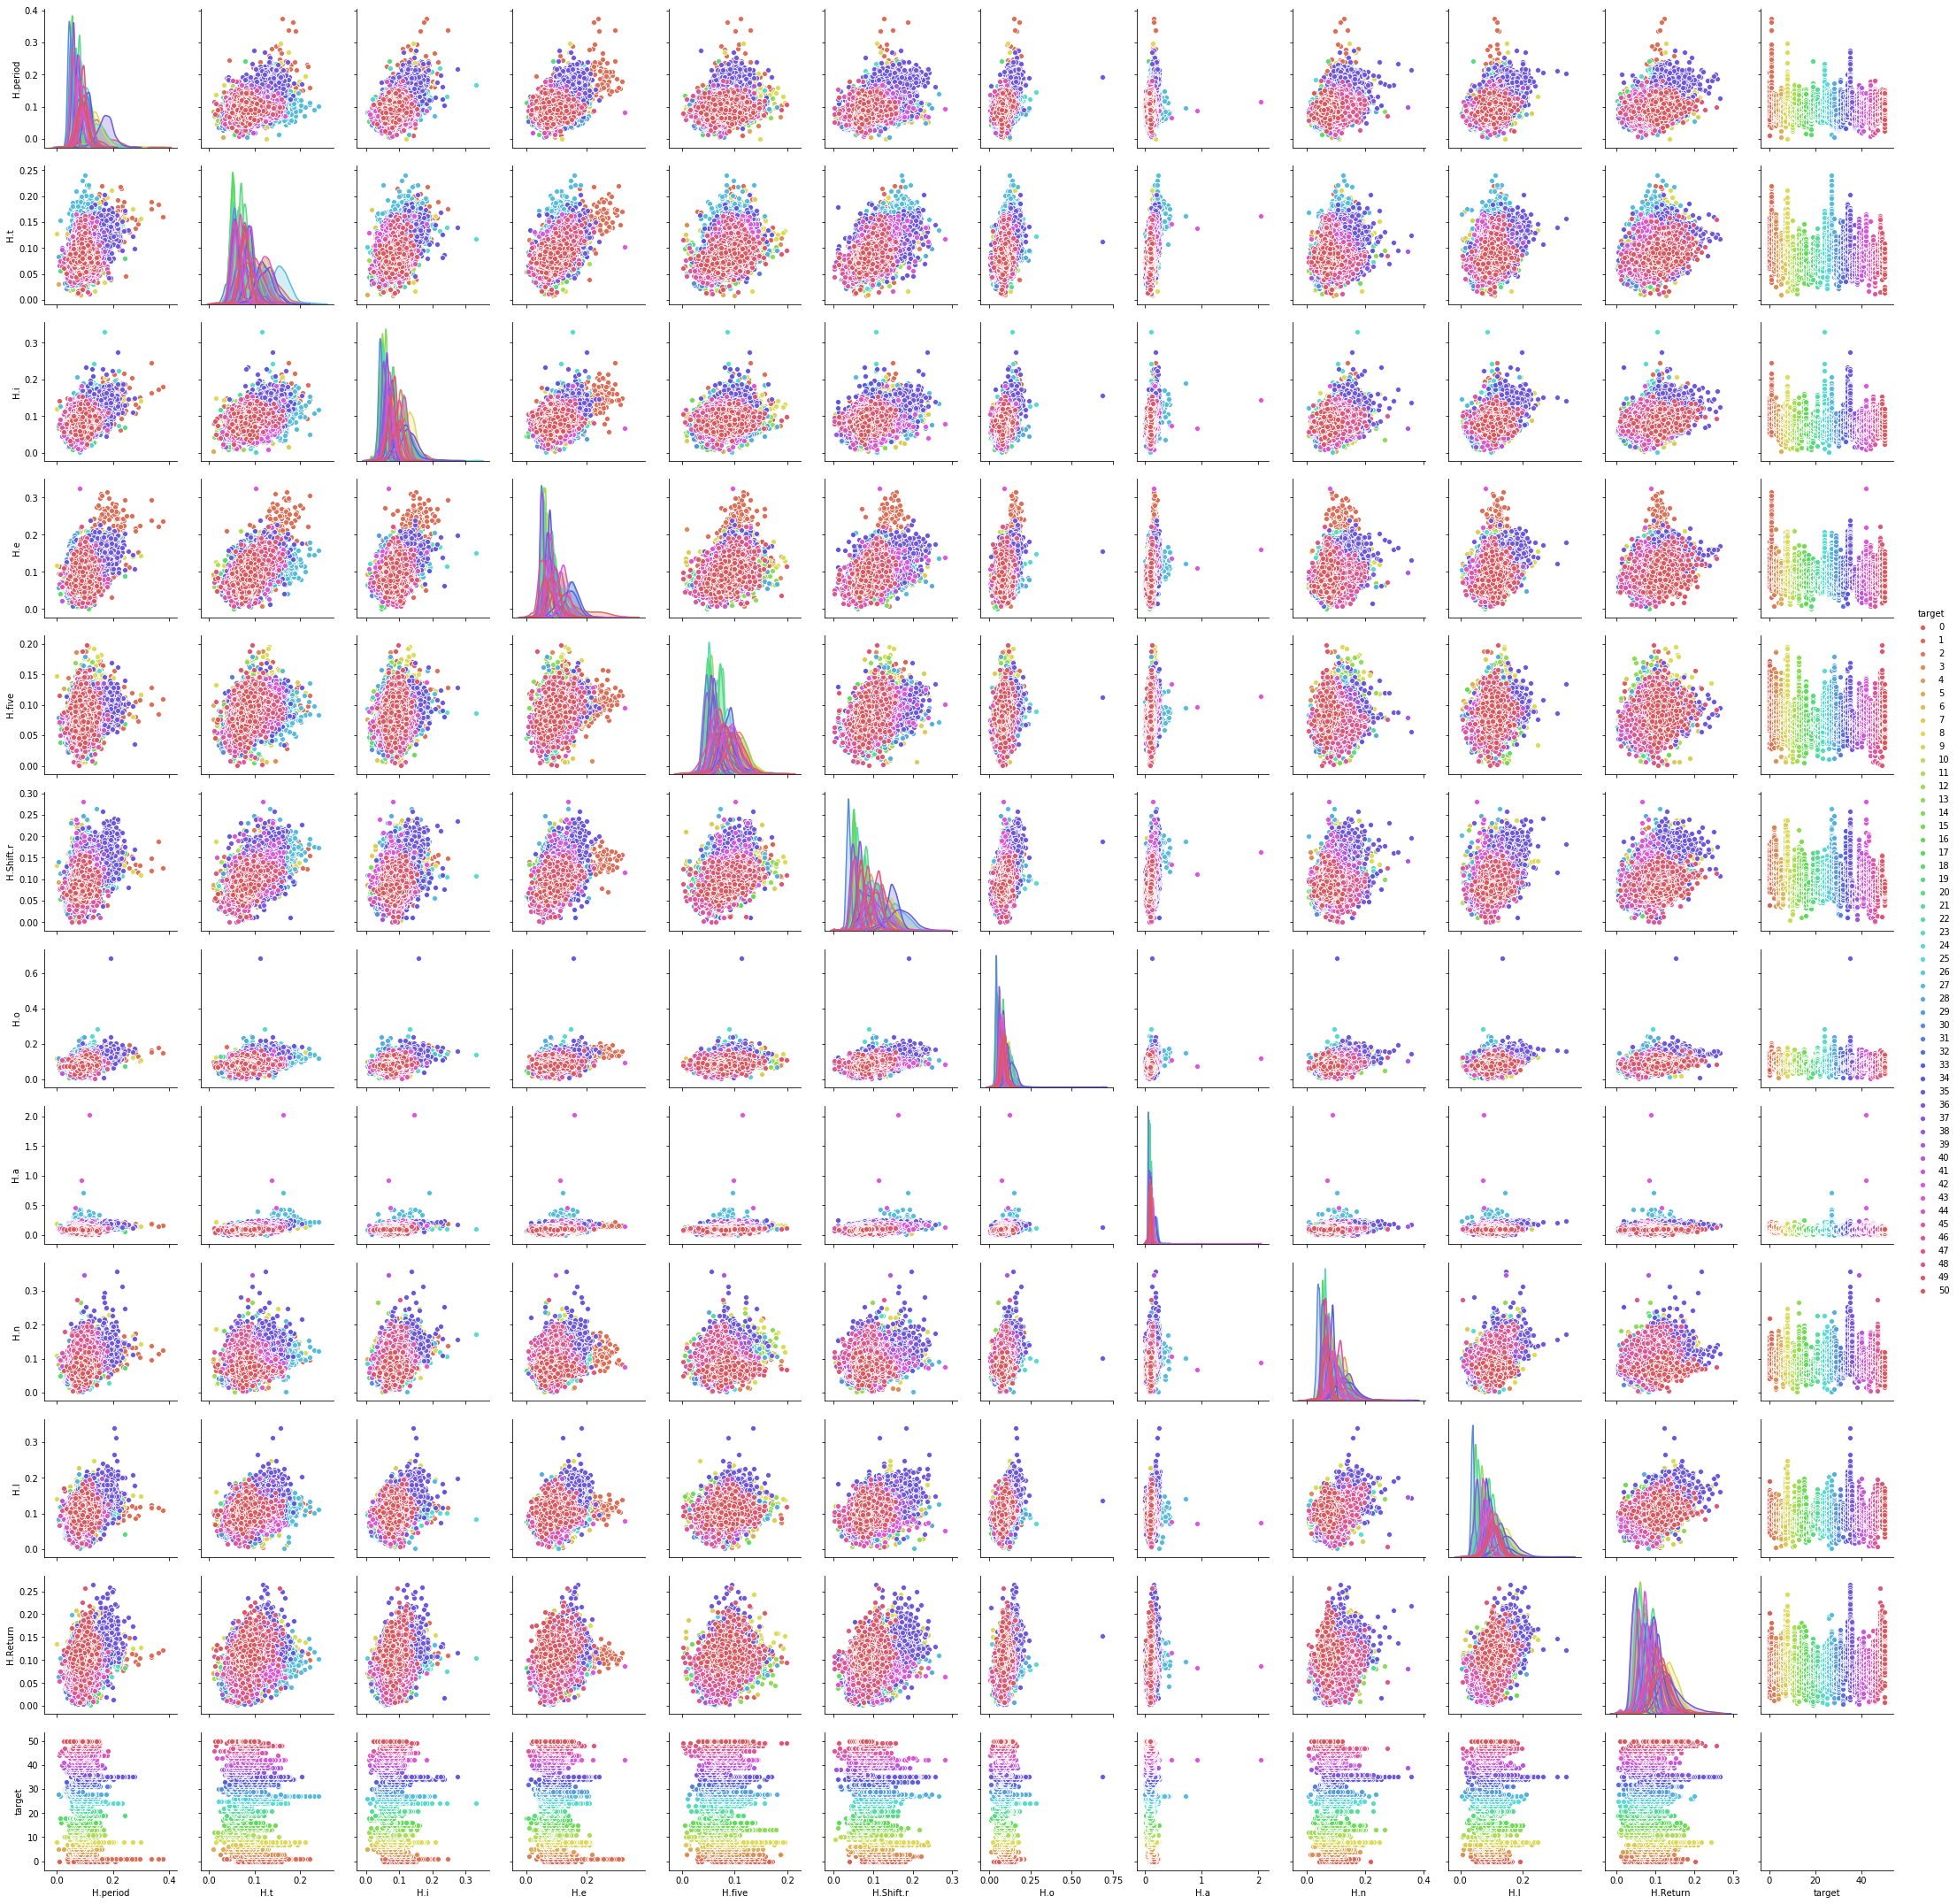

In [29]:
sns.pairplot(df[hold_features + ['target']], hue='target', palette=sns.color_palette("hls", 51))

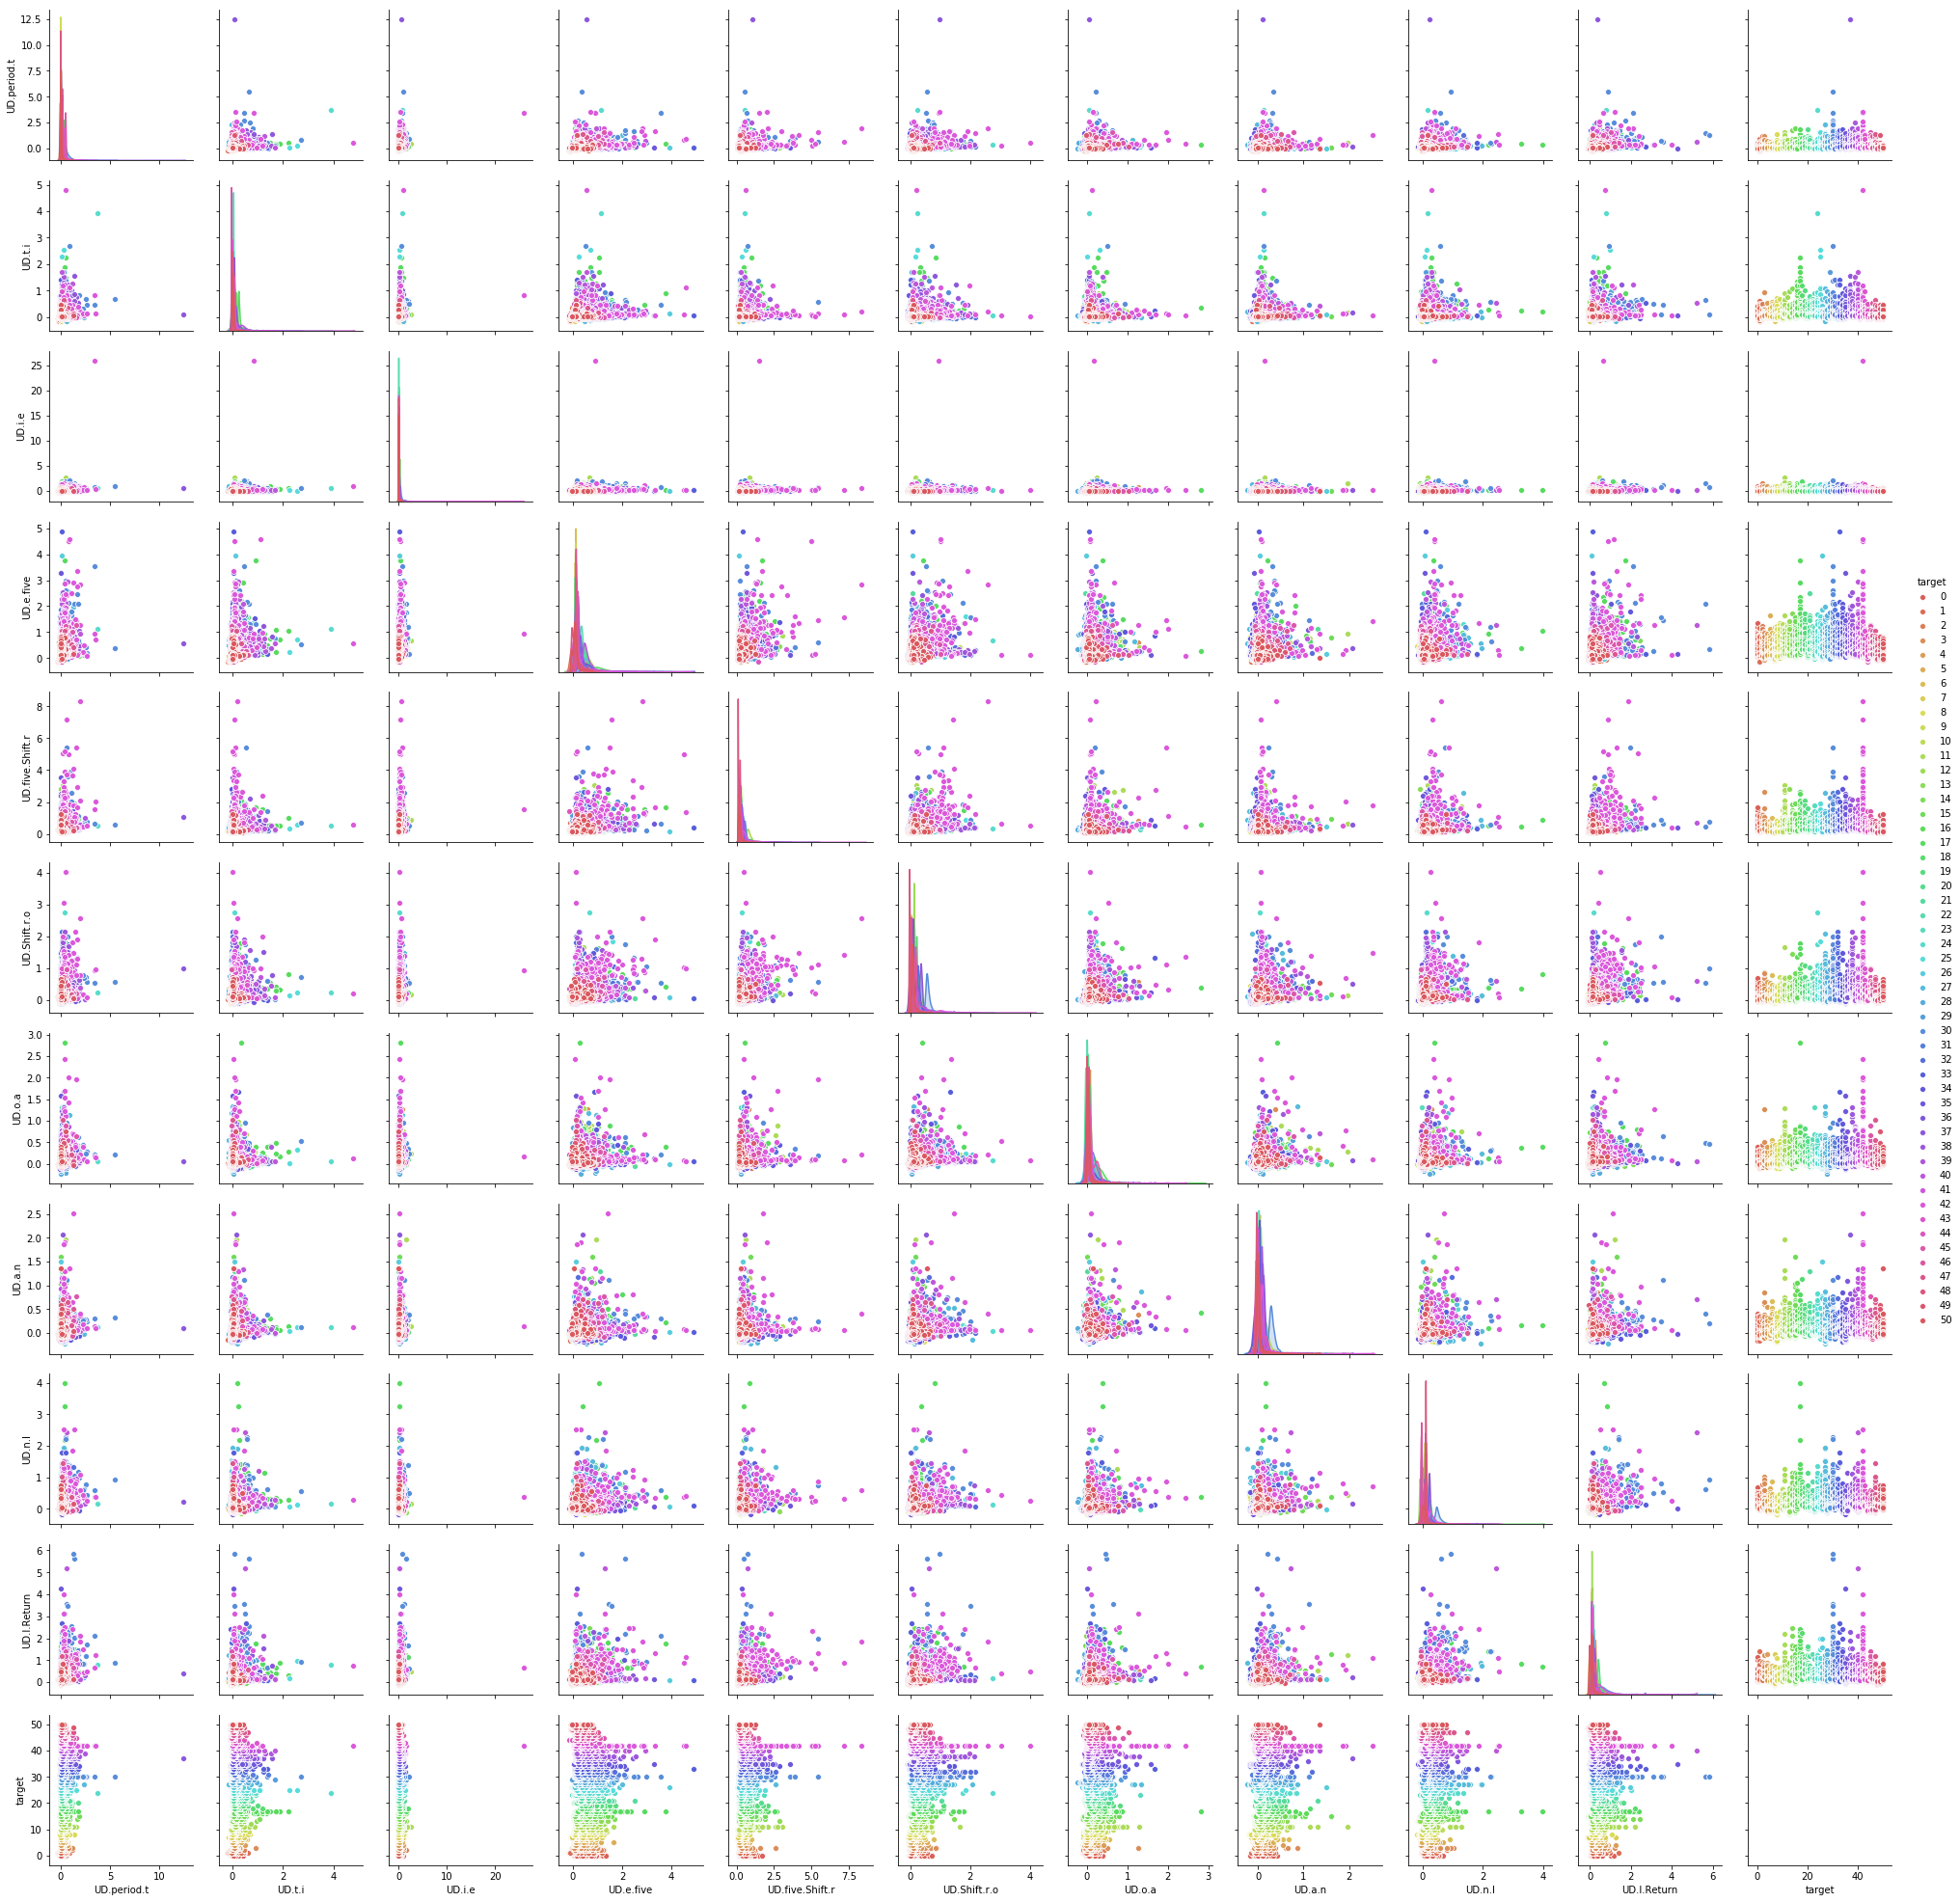

In [14]:
sns.pairplot(df[ud_features + ['target']], hue='target', palette=sns.color_palette("hls", 51))

对数据做PCA分析，初判数据是否存在线性特性。

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#去掉一些outlier
df = df[(df['H.o']<=0.5)&(df['H.a']<=0.5)&(df['UD.period.t']<=5)&(df['UD.t.i']<=5)&(df['UD.i.e']<=5)]
#取全部用户数据
#X = df.drop(['target'], axis=1)
#y = df['target'].values
#取前10个用户
#X = df.drop(['target'], axis=1)[0:4000]
#y = df['target'][0:4000].values
#取前4个用户
X = df.drop(['target'], axis=1)[0:1600]
y = df['target'][0:1600].values

scaler = StandardScaler()      #对X的列进行标准化
X_scaled = scaler.fit_transform(X)

pca = PCA(random_state=17)
pca.fit(X_scaled)

pca_result = pca.transform(X_scaled)
pca_result.shape

(1600, 33)

查看pca转换后的分量对数据的解释贡献

Text(0.5, 1.0, 'pricipal component nums for data infromantion')

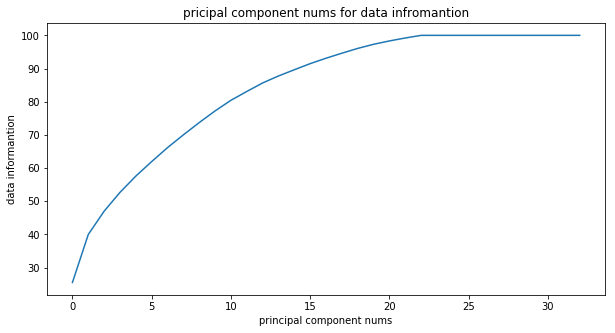

In [10]:
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel('principal component nums')
plt.ylabel('data informantion')
plt.title('pricipal component nums for data infromantion')

观察PCA前两个主变量的值（principal component1和principal component2），可以看到很难区分开不同用户。这种情况有3种可能：
1.原则上，不同用户可以分开，但前两个主分量没有足够的信息来做到这一点。
2.原则上，不同用户以分开，但需要采取其他非线性转换方法，以便可以明确区分。
3.原则上，不同用户不可分。

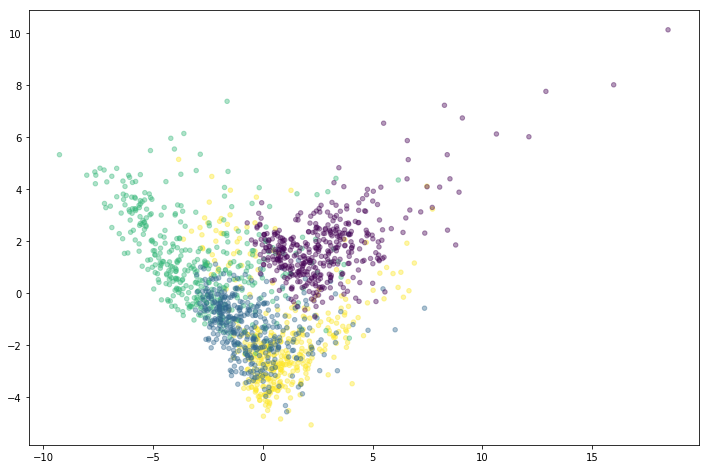

In [12]:
plt.figure(figsize=(12,8))
#全部数据
#plt.scatter(pca_result[:,0], pca_result[:,1], c=df['target'], s=2, cmap='viridis_r', alpha=0.4)
#取前10个用户
#plt.scatter(pca_result[:,0], pca_result[:,1], c=df['target'][0:4000], s=2, cmap='viridis_r', alpha=0.4)
#取前5个用户
plt.scatter(pca_result[:,0], pca_result[:,1], c=df['target'][0:1600], s=20, cmap='viridis_r', alpha=0.4)

用t-SNE分析数据，考虑是不是能用非线性方法区分用户。下面图示表明，大部分数据可以区分。数据具有非线性特性。

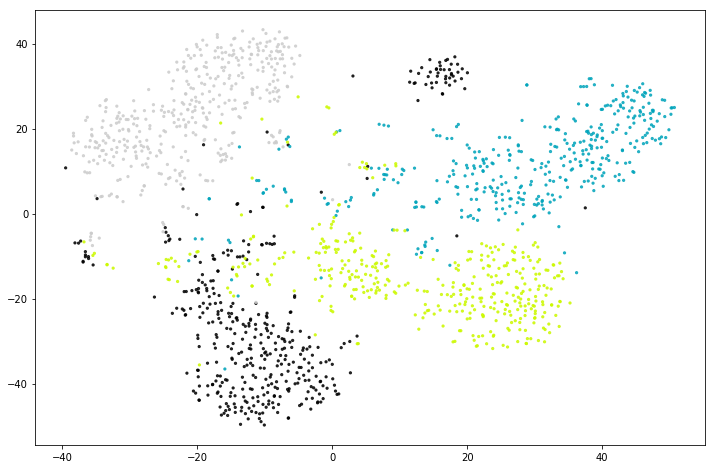

In [13]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=23)
tsne_representation = tsne.fit_transform(X_scaled, y=df['target'])

plt.figure(figsize=(12,8))
#plt.scatter(tsne_representation[:,0], tsne_representation[:,1], c=df['target'], s=5, cmap='viridis_r', alpha=.8)
#plt.scatter(tsne_representation[:,0], tsne_representation[:,1], c=df['target'][0:1600], s=5, cmap='viridis_r', alpha=.8)
plt.scatter(tsne_representation[:,0], tsne_representation[:,1], c=df['target'][0:1600], s=5, cmap='nipy_spectral', alpha=.8)


观察rep和session与H或UD的关系

Text(0, 0.5, 'mean')

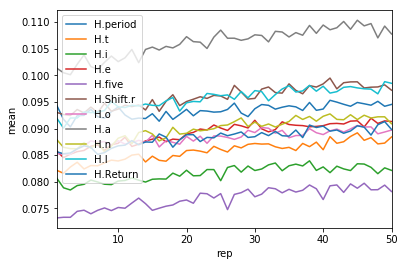

In [37]:
#下面观察H特征稳定性（与rep和session的相关性),可以看到一个上升的趋势：在按键时休息一下！
#观察H特征（注意，这里是对所有用户求了平均值）
df.groupby(['rep'])[hold_features].agg(np.mean).plot()
plt.xlabel('rep')
plt.ylabel('mean')

Text(0, 0.5, 'mean')

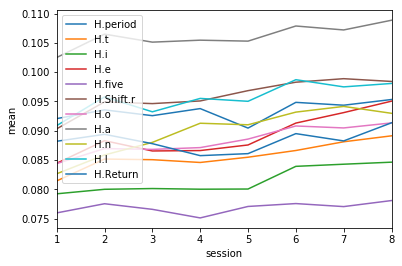

In [38]:
df.groupby(['sessionIndex'])[hold_features].agg(np.mean).plot()
plt.xlabel('session')
plt.ylabel('mean')

下面观察UD特征的稳定性（与rep和session的相关性),可以看到一个下降的趋势（rep的前5-10次），之后就比较平稳了，说明通过前几次的击键，肌肉熟悉了击键内容和击键动作。

Text(0, 0.5, 'mean')

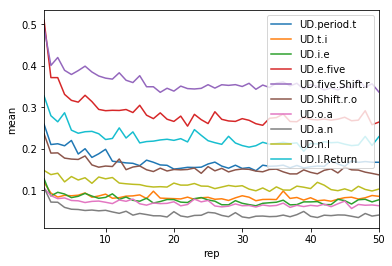

In [39]:
df.groupby(['rep'])[ud_features].agg(np.mean).plot()
plt.xlabel('rep')
plt.ylabel('mean')

Text(0, 0.5, 'mean')

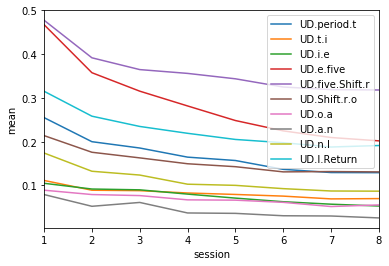

In [41]:
df.groupby(['sessionIndex'])[ud_features].agg(np.mean).plot()
plt.xlabel('session')
plt.ylabel('mean')

尽管上面的结果表明数据存在与rep和session相关的特性，但在实际应用中（用户认证）时不应考虑它们，所以下面将去掉相关属性。

In [14]:
df.drop(['sessionIndex'], axis=1, inplace=True)

下面开始选择特征和模型

In [15]:
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
#计算多类roc_auc值，这里用macro，而没有用micro。
def custom_multi_roc_auc_score(y_true, y_pred, avg='macro'):
    #构建一个转换对象，将字符串（这里是y_true）进行数字化，数字范围从0开始，转换为一个列向量。
    lb = LabelBinarizer()
    return roc_auc_score(lb.fit_transform(y_true), y_pred, average=avg)
multi_roc_auc_scorer = make_scorer(custom_multi_roc_auc_score, needs_proba=True)

In [16]:
#交叉验证，4folder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
strtf_cv = StratifiedKFold(n_splits=4, random_state=17)
#定义cross_validation结果图形显示函数
def plot_cv_results(grid, param='param_n_neighbors', scale='linear'):
    '''
    This function plots gridsearch results for given grid search object. It can only plot 
    results for one parameter 。只能显示一个参数的结果（将超参数综合成一个参数？）
    '''
    plt.figure(figsize=(10,6))
    plt.plot(grid.cv_results_[param].tolist(), grid.cv_results_['mean_train_score'], label='Train Score')
    plt.fill_between(grid.cv_results_[param].tolist(), 
                     grid.cv_results_['mean_train_score'] - grid.cv_results_['std_train_score']/2, 
                     grid.cv_results_['mean_train_score'] + grid.cv_results_['std_train_score']/2, 
                     alpha=.3)
    plt.plot(grid.cv_results_[param].tolist(), grid.cv_results_['mean_test_score'], label='Validation Score')
    plt.fill_between(grid.cv_results_[param].tolist(), 
                     grid.cv_results_['mean_test_score'] - grid.cv_results_['std_test_score']/2, 
                     grid.cv_results_['mean_test_score'] + grid.cv_results_['std_test_score']/2, 
                     alpha=.3)
    plt.ylabel('ROC AUC')
    plt.xlabel(param.strip('param_'))
    plt.title('Validation Curve')
    plt.legend()
    plt.xscale(scale)    #scale如果是linear的话，刻度就是线性的。
    plt.show()

In [18]:
#将H特征与UD特征合起来
X = df[ud_features + hold_features + ['rep']]
y = df['target']
#数据混淆后分成训练集和测试集（30%）
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=19, shuffle=True)
#对数据列进行标准化，如果不标准化呢？标准化后就符合正态分布了，其实原始是不符合正态分布。
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

用KNeighborsClassifier分类器
这里要选择的超参数有：
1.n_neighbors：值越小，模型越复杂
2.p: 明科夫斯基参数。p=1是曼哈顿距离，p=2是欧几里得距离。默认是2。

In [19]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_jobs=-1)
#k在1,2,3...,9,10,20,30,...150中选。
knn_params = {'n_neighbors': list(np.arange(1, 10)) + list(np.linspace(10, 150, 15, dtype=int))}
#交叉验证，得到最佳ROC_AUC和最好参数。
#如果向量值标准化后，得到的结果是：ROC_AUC=0.9892501543948976，n_neighbors=80。
#如果向量值没有标准化，得到的结果是：ROC_AUC=0.8027877034483448，n_neighbors=20。
#这里默认用欧几里得距离
knn_grid = GridSearchCV(knn_clf, param_grid=knn_params, n_jobs=-1, scoring=multi_roc_auc_scorer, cv=strtf_cv)
#knn_grid.fit(X_train_scaled, y_train)  #标准化数据
knn_grid.fit(X_train, y_train)          #未标准化数据
print('ROC AUC最佳值:', knn_grid.best_score_)
print('最好参数:', knn_grid.best_params_)

ROC AUC最佳值: 0.8027877034483448
最好参数: {'n_neighbors': 20}


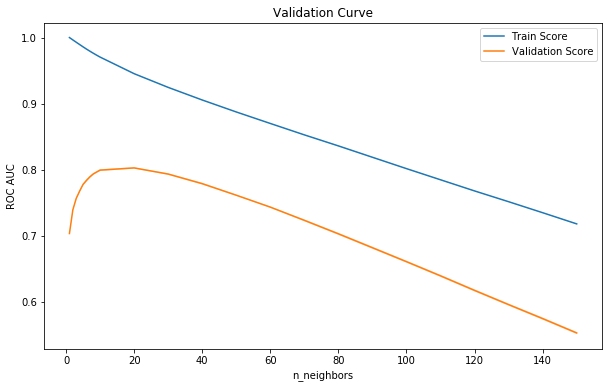

In [20]:
#画验证曲线
plot_cv_results(knn_grid, param='param_n_neighbors')

In [21]:
#标准化数据基础上计算roc_auc的平均值，0.9897841367102398，和训练的结果相比，居然还高了一些。这说明模型没有被接受和正确使用。
#custom_multi_roc_auc_score(y_test, knn_grid.best_estimator_.predict_proba(X_test_scaled))
#未标准化数据基础上计算roc_auc的平均值，0.8390821409788358，和训练的结果相比，居然还高了一些。
y_predict = knn_grid.best_estimator_.predict_proba(X_test)
custom_multi_roc_auc_score(y_test,y_predict)

0.8390821409788358

测试结果要好于训练结果，意味着异常。考虑到样本的不平衡。正负样本为1:50。如果模型偏“悲观”，即只判断所有的为负样本，也能获得50/51=98%的准确率。